In [1]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import json
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#OUTPUT VALIDATION 

In [ ]:
filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_gunshot.json"
filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_siren.json"
filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_scream.json"


samplerate = 22050
longitudMaxAudio = 4
valuesNmfcc = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]    #Valores de parametro a variar para el numero de coeficientes MFCC
valuesNfft = [256, 512, 1024, 2048, 4096]     #[256, 512, 1024, 2048, 4096] #Valores de parametro a variar para la longitud de la FFT
valuesWinL = [256, 512, 1024, 2048, 4096]      #[256, 512, 1024, 2048, 4096]   #Valores de parametro a variar para el tamaño de ventana, este debe ser menor o igual a NFFT, la función hace padding con 0
valuesHopL = [0.25, 0.5, 0.75]                 #Valores de parametro a variar para el overlaping opuesto de hop_length
valuesKernelSize = [2, 3, 5]                  #Valores de parametro de tamaño de kernel a variar dentro del modelo


def validateExperimentOut(filenameOutput):

  # 1. Read json file
  with open(filenameOutput, "r") as f:
      data = json.load(f)
      f.close() 
  # 2. Update json object
  print(len(data["Experiments"]))
  #print(data["Experiments"][2024])
  #Experiment = data["Experiments"][0]
  #print("Type:", type(Experiment))
  #print('N_MFCC=', Experiment['N_MFCC'])

  Nexperiments = 0
  for Nmfcc in valuesNmfcc:                     #Loop para variar valores del parametro n_mfcc => Numero de coeficientes MFCC
    for Nfft in valuesNfft:                         #Loop para variar valores del parametro n_fft => Tamaño del la FFT
      for iterableNwinL in valuesWinL:              #Loop para variar valores del parametro Win_Length => Longitud de la ventana de muestreo
        if iterableNwinL<=Nfft:
          NwinL = iterableNwinL
        else:
          continue
        for iterableNhopL in valuesHopL:            #Loop para variar valores del parametro Hop_Length => Overlaping
          NhopL = int(iterableNhopL*NwinL)
          for k_size in valuesKernelSize:           #Loop para variar valores del parametro kernel size => Tamaño del kernel de capas convolucionales
            Experiment = data["Experiments"][Nexperiments]

            if(Experiment['N_MFCC']!=Nmfcc or Experiment['Nfft']!=Nfft or Experiment['NwinL']!=NwinL or Experiment['NhopL']!=NhopL or Experiment['Ksize']!=k_size):
              print("NOT FOUND COINCIDENCE IN FOLLOW EXPERIMENT: ")
              print("EXPECTED:")
              print(f'N_MFCC= {Nmfcc}, Nfft= {Nfft}, NwinL= {NwinL}, NhopL= {NhopL}, k_size= {k_size}')
              print("FOUND:")
              print('N_MFCC= ', Experiment['N_MFCC'])
              print('Nfft= ', Experiment['Nfft'])
              print('NwinL= ', Experiment['NwinL'])
              print('NhopL= ', Experiment['NhopL'])
              print('k_size=', Experiment['Ksize'])
              return
            Nexperiments = Nexperiments + 1

  print('Output File Experiments Correct')
  print(f'Numero total experimentos debieron correrse = {Nexperiments},')
  print(f'Numero total experimentos corridos = { len(data["Experiments"])},')


filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_gunshot.json"
filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_siren.json"
filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_scream.json"

validateExperimentOut(filenameOutputGun)
validateExperimentOut(filenameOutputSiren)
validateExperimentOut(filenameOutputScream)

Experiment = {
  'N_MFCC': '',
  'Nfft': '',
  'NwinL': '',
  'NhopL': '',
  'Ksize': '',
  'durationAvgPreprocs': '',
  #'models': models,
  #'histories': histories,
  'reports': '',
  'cmatrixs': '',
  'trainAcc': '',
  'testAcc': '',
  'trainTimes': '',
  'numberEpochsRan': '',
  'specGPU': '',
  'specCPU': '',
  'specCore': ''
}




2025
Output File Experiments Correct
Numero total experimentos debieron correrse = 2025,
Numero total experimentos corridos = 2025,
2025
Output File Experiments Correct
Numero total experimentos debieron correrse = 2025,
Numero total experimentos corridos = 2025,
2025
Output File Experiments Correct
Numero total experimentos debieron correrse = 2025,
Numero total experimentos corridos = 2025,


#OUTPUT AVERAGE DATASET

In [ ]:

def createAVGDataOut(filenameOutput, AVGDataOutputPath):
  import datetime
  import pandas as pd     # Import pandas library

  # 1. Read json file
  with open(filenameOutput, "r") as f:
      data = json.load(f)
      f.close() 
  # 2. Update json object
  print(len(data["Experiments"]))

  Nexperiments = 0

  dfExperiments = pd.DataFrame(columns=['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Overlap', 'Ksize', 'AVGPreprocesTime', 'AVGTrainTime', 'F1Score', 'TestAcc', 'EpochsRan'])      # Create the pandas DataFrame with column name is provided explicitly
  for expIterator in range(len(data["Experiments"])): 
    Experiment = data["Experiments"][expIterator]
    NMFCC = Experiment['N_MFCC']
    Nfft = Experiment['Nfft']
    NwinL = Experiment['NwinL']
    NhopL = Experiment['NhopL']
    Overlap = float(1-NhopL/NwinL)
    Ksize = Experiment['Ksize']
    timeRef = datetime.datetime.strptime('00:00:00.0',"%H:%M:%S.%f")
    durationTimePrep = datetime.datetime.strptime(Experiment['durationAvgPreprocs'], '%H:%M:%S.%f')
    AVGPreprocesTime = durationTimePrep - timeRef
    f1_scores = 0
    testAccs = 0
    trainTimes = datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    for i in range(5):
      report = Experiment['reports'][i]
      f1_scores += float(report.split()[7])*100
      testAccs += float(report.split()[15])*100
      trainTime = Experiment['trainTimes'][i]
      trainTime = datetime.datetime.strptime(Experiment['trainTimes'][i], '%H:%M:%S.%f')
      trainTime = trainTime - timeRef
      trainTimes = trainTimes + trainTime

    AVGTrainTime = trainTimes/5
    F1Score = f1_scores/5
    TestAcc = testAccs/5
    EpochsRan = round(sum(Experiment['numberEpochsRan']) / len(Experiment['numberEpochsRan']))
    
    '''print("DATA OF EXPERIMENT:")
    print('Nfft= ', Nfft)
    print('NwinL= ', NwinL)
    print('NhopL= ', Experiment['NhopL'])
    print('Overlap= ', Overlap)
    print('k_size=', Ksize)
    print('AVG durationAvgPreprocs= ',AVGPreprocesTime)
    print('AVG trainTime= ', AVGTrainTime)
    print('AVG f1-scores= ', F1Score)
    print('AVG testAccs= ', TestAcc)  
    print('AVG EpochsRan= ', EpochsRan)'''

    # Insert Dict to the dataframe using DataFrame.append()
    newExperiment = {'NMFCC':NMFCC, 'Nfft':Nfft, 'NwinL':NwinL, 'NhopL':NhopL, 'Overlap': Overlap, 'Ksize':Ksize, 'AVGPreprocesTime':AVGPreprocesTime, 'AVGTrainTime':AVGTrainTime, 'F1Score':F1Score, 'TestAcc':TestAcc, 'EpochsRan':EpochsRan}
    dfExperiments = dfExperiments.append(newExperiment, ignore_index=True)
    
    '''print('N_MFCC= ', Experiment['N_MFCC'])
    print('Nfft= ', Experiment['Nfft'])
    print('NwinL= ', Experiment['NwinL'])
    print('NhopL= ', Experiment['NhopL'])
    print('k_size=', Experiment['Ksize'])
    print('durationAvgPreprocs= ', Experiment['durationAvgPreprocs'])
    print('reports= ', Experiment['reports'][0])
    print('cmatrixs= ', Experiment['cmatrixs'])
    print('trainAcc= ', Experiment['trainAcc'])
    print('testAcc=', Experiment['testAcc'])
    print('trainTimes= ', Experiment['trainTimes'])
    print('numberEpochsRan= ', Experiment['numberEpochsRan'])
    print('specGPU= ', Experiment['specGPU'])
    print('specCPU= ', Experiment['specCPU'])
    print('specCore=', Experiment['specCore'])'''

  #Export dataframe of experiments
  AVGDataOutputPath  
  dfExperiments.to_csv(AVGDataOutputPath)
  #dfExperiments.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv')
  print("FILE SAVED CORRECT WAY")
  print(dfExperiments.shape)


filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_gunshot.json"
AVGDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv"

filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_siren.json"
AVGDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_siren.csv"

filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_scream.json"
AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_scream.csv"



createAVGDataOut(filenameOutputGun, AVGDataOutputPathGun)
createAVGDataOut(filenameOutputSiren, AVGDataOutputPathSiren)
createAVGDataOut(filenameOutputScream, AVGDataOutputPathScream)




2025
FILE SAVED CORRECT WAY
(2025, 11)
2025
FILE SAVED CORRECT WAY
(2025, 11)
2025
FILE SAVED CORRECT WAY
(2025, 11)


#OUTPUT BEST RESULT DATASET

In [ ]:

def createBestDataOut(filenameOutput, BestDataOutputPath):
  import datetime
  import pandas as pd     # Import pandas library

  # 1. Read json file
  with open(filenameOutput, "r") as f:
      data = json.load(f)
      f.close() 
  # 2. Update json object
  print(len(data["Experiments"]))

  Nexperiments = 0

  dfExperiments = pd.DataFrame(columns=['NMFCC', 'Nfft', 'NwinL', 'NhopL', 'Overlap', 'Ksize', 'AVGPreprocesTime', 'TrainTime', 'F1Score', 'TestAcc', 'EpochsRan'])      # Create the pandas DataFrame with column name is provided explicitly
  for expIterator in range(len(data["Experiments"])): 
    Experiment = data["Experiments"][expIterator]
    NMFCC = Experiment['N_MFCC']
    Nfft = Experiment['Nfft']
    NwinL = Experiment['NwinL']
    NhopL = Experiment['NhopL']
    Overlap = float(1-NhopL/NwinL)
    Ksize = Experiment['Ksize']
    timeRef = datetime.datetime.strptime('00:00:00.0',"%H:%M:%S.%f")
    durationTimePrep = datetime.datetime.strptime(Experiment['durationAvgPreprocs'], '%H:%M:%S.%f')
    AVGPreprocesTime = durationTimePrep - timeRef
    f1_scores = 0
    testAccs = 0
    trainTimes = datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    report = Experiment['reports'][0]
    f1_score = float(report.split()[7])*100
    testAcc = float(report.split()[15])*100
    trainTime = Experiment['trainTimes'][0]
    trainTime = datetime.datetime.strptime(Experiment['trainTimes'][0], '%H:%M:%S.%f')
    trainTime = trainTime - timeRef
    EpochsRan = Experiment['numberEpochsRan'][0]
    for i in range(5):
      report = Experiment['reports'][i]
      f1_scores = float(report.split()[7])*100
      testAccs = float(report.split()[15])*100
      #print(f1_scores)
      if(f1_scores>f1_score):
        f1_score = f1_scores
        testAcc = testAccs
        trainTime = Experiment['trainTimes'][i]
        trainTime = datetime.datetime.strptime(Experiment['trainTimes'][i], '%H:%M:%S.%f')
        trainTime = trainTime - timeRef
        EpochsRan = Experiment['numberEpochsRan'][i]
      elif(f1_scores==f1_score):
        if(testAccs>testAcc):
          f1_score = f1_scores
          testAcc = testAccs
          trainTime = Experiment['trainTimes'][i]
          trainTime = datetime.datetime.strptime(Experiment['trainTimes'][i], '%H:%M:%S.%f')
          trainTime = trainTime - timeRef
          EpochsRan = Experiment['numberEpochsRan'][i]
      

    TrainTime = trainTime
    F1Score = f1_score
    TestAcc = testAcc

    
    '''print("DATA OF EXPERIMENT:")
    print('Nfft= ', Nfft)
    print('NwinL= ', NwinL)
    print('NhopL= ', Experiment['NhopL'])
    print('Overlap= ', Overlap)
    print('k_size=', Ksize)
    print('AVG durationAvgPreprocs= ',AVGPreprocesTime)
    print('AVG trainTime= ', AVGTrainTime)
    print('AVG f1-scores= ', F1Score)
    print('AVG testAccs= ', TestAcc)  
    print('AVG EpochsRan= ', EpochsRan)'''

    # Insert Dict to the dataframe using DataFrame.append()
    newExperiment = {'NMFCC':NMFCC, 'Nfft':Nfft, 'NwinL':NwinL, 'NhopL':NhopL, 'Overlap': Overlap, 'Ksize':Ksize, 'AVGPreprocesTime':AVGPreprocesTime, 'TrainTime':TrainTime, 'F1Score':F1Score, 'TestAcc':TestAcc, 'EpochsRan':EpochsRan}
    dfExperiments = dfExperiments.append(newExperiment, ignore_index=True)
    
    '''print('N_MFCC= ', Experiment['N_MFCC'])
    print('Nfft= ', Experiment['Nfft'])
    print('NwinL= ', Experiment['NwinL'])
    print('NhopL= ', Experiment['NhopL'])
    print('k_size=', Experiment['Ksize'])
    print('durationAvgPreprocs= ', Experiment['durationAvgPreprocs'])
    print('reports= ', Experiment['reports'][0])
    print('cmatrixs= ', Experiment['cmatrixs'])
    print('trainAcc= ', Experiment['trainAcc'])
    print('testAcc=', Experiment['testAcc'])
    print('trainTimes= ', Experiment['trainTimes'])
    print('numberEpochsRan= ', Experiment['numberEpochsRan'])
    print('specGPU= ', Experiment['specGPU'])
    print('specCPU= ', Experiment['specCPU'])
    print('specCore=', Experiment['specCore'])'''

  #Export dataframe of experiments
  #AVGDataOutputPath  
  dfExperiments.to_csv(BestDataOutputPath)
  #dfExperiments.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv')
  print("FILE SAVED CORRECT WAY")
  print(dfExperiments.shape)


filenameOutputGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_gunshot.json"
BestDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/Best_data_out_gunshot.csv"

filenameOutputSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_siren.json"
BestDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/Best_data_out_siren.csv"

filenameOutputScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/DSE_scream.json"
BestDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/Best_data_out_scream.csv"



createBestDataOut(filenameOutputGun, BestDataOutputPathGun)
createBestDataOut(filenameOutputSiren, BestDataOutputPathSiren)
createBestDataOut(filenameOutputScream, BestDataOutputPathScream)

2025
FILE SAVED CORRECT WAY
(2025, 11)
2025
FILE SAVED CORRECT WAY
(2025, 11)
2025
FILE SAVED CORRECT WAY
(2025, 11)


#LOAD AND EVALUATE OUTPUT BEST RESULT DATASET

In [ ]:

BestDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/Best_data_out_gunshot.csv"

BestDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/Best_data_out_siren.csv"

BestDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/Best_data_out_scream.csv"



import datetime
import pandas as pd     # Import pandas library


dfExperiments = pd.read_csv(BestDataOutputPathScream, index_col=0)
dfExperiments
dfExperiments.sort_values(by='F1Score', ascending=False)

,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,TrainTime,F1Score,TestAcc,EpochsRan
388,9,4096,2048,512,0.75,3,0 days 00:00:00.045980,0 days 00:02:36.186084,100.0,100.0,80
1333,30,4096,2048,512,0.75,3,0 days 00:00:00.046404,0 days 00:03:22.569511,100.0,100.0,80
523,12,4096,2048,512,0.75,3,0 days 00:00:00.048121,0 days 00:02:22.549751,100.0,100.0,80
1198,27,4096,2048,512,0.75,3,0 days 00:00:00.046140,0 days 00:02:40.080017,100.0,100.0,80
1603,36,4096,2048,512,0.75,3,0 days 00:00:00.047421,0 days 00:02:24.969833,100.0,100.0,80
...,...,...,...,...,...,...,...,...,...,...,...
21,3,512,512,256,0.50,2,0 days 00:00:00.037303,0 days 00:00:10.449117,76.0,75.0,21
147,6,512,256,128,0.50,2,0 days 00:00:00.040985,0 days 00:00:07.867948,76.0,73.0,17
9,3,512,256,64,0.75,2,0 days 00:00:00.045559,0 days 00:00:12.749544,74.0,79.0,21
144,6,512,256,64,0.75,2,0 days 00:00:00.045599,0 days 00:00:13.100280,73.0,78.0,21


#LOAD AND EVALUATE OUTPUT AVG RESULT DATASET

#GUNSHOT EXPERIMENTS ANALYSIS

In [ ]:
AVGDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv"

AVGDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_siren.csv"

AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_scream.csv"



import datetime
import pandas as pd     # Import pandas library


dfExperiments = pd.read_csv(AVGDataOutputPathGun, index_col=0)
dfExperiments
dfExperiments.sort_values(by='F1Score', ascending=False)

,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan
1883,42,4096,4096,1024,0.75,5,0 days 00:00:00.061931,0 days 00:01:47.731802,97.2,97.2,80
1343,30,4096,4096,1024,0.75,5,0 days 00:00:00.057609,0 days 00:01:42.529743,97.0,97.2,80
1613,36,4096,4096,1024,0.75,5,0 days 00:00:00.068520,0 days 00:01:55.461854,97.0,97.0,80
1748,39,4096,4096,1024,0.75,5,0 days 00:00:00.055669,0 days 00:01:33.194341,97.0,97.2,80
266,6,4096,4096,2048,0.50,5,0 days 00:00:00.064598,0 days 00:01:48.970059,96.8,96.8,78
...,...,...,...,...,...,...,...,...,...,...,...
282,9,512,256,128,0.50,2,0 days 00:00:00.062682,0 days 00:00:56.805968,63.2,76.6,38
573,15,1024,256,192,0.25,2,0 days 00:00:00.054346,0 days 00:00:44.362996,63.0,75.8,40
543,15,256,256,128,0.50,2,0 days 00:00:00.052737,0 days 00:00:48.998795,56.8,73.6,42
546,15,256,256,192,0.25,2,0 days 00:00:00.051326,0 days 00:00:37.258240,53.8,71.4,35


In [ ]:
dfExperiments.groupby(['NMFCC'])['F1Score'].mean()

NMFCC
3     87.078519
6     87.536296
9     89.074074
12    89.817778
15    88.940741
18    90.050370
21    90.327407
24    90.440000
27    90.429630
30    90.451852
33    90.877037
36    91.223704
39    91.168889
42    91.140741
45    91.262222
Name: F1Score, dtype: float64

Text(0.5, 1.0, 'F1-Score in Models by NMFCC Value')

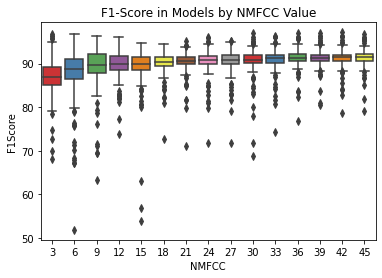

In [ ]:
import seaborn as sb

sb.boxplot(x='NMFCC', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by NMFCC Value")


Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

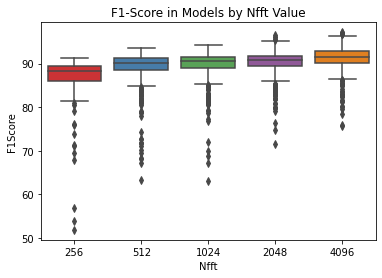

In [ ]:

sb.boxplot(x='Nfft', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Nfft Value")

Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

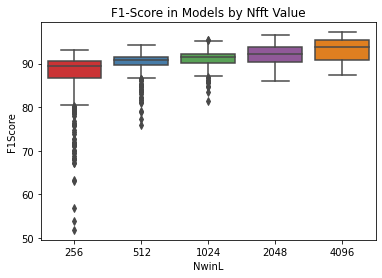

In [ ]:
sb.boxplot(x='NwinL', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Nfft Value")

Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

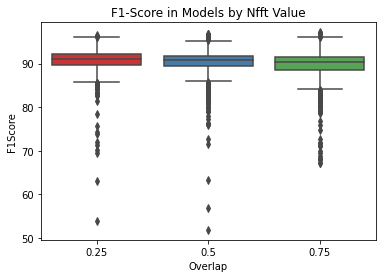

In [ ]:
sb.boxplot(x='Overlap', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Nfft Value")

Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

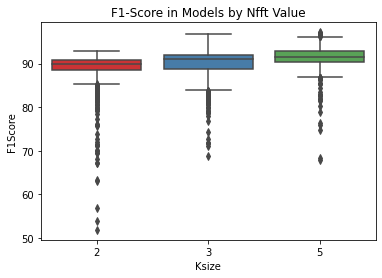

In [ ]:
sb.boxplot(x='Ksize', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Nfft Value")

In [ ]:
import statsmodels.api as sm 

formula = 'F1Score ~ NMFCC + Nfft'
model = sm.formula.ols(formula, data=dfExperiments).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
NMFCC,2620.588038,1.0,200.654039,1.684054e-43
Nfft,2956.051456,1.0,226.339911,1.438608e-48
Residual,26407.786501,2022.0,NaN,NaN


In [ ]:
formula = 'F1Score ~ NMFCC + Nfft + NMFCC:Nfft'
model = sm.formula.ols(formula, data=dfExperiments).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
NMFCC,2620.588038,1.0,204.084325,3.523048e-44
Nfft,2956.051456,1.0,230.209311,2.517107e-49
NMFCC:Nfft,456.707631,1.0,35.567158,2.901156e-09
Residual,25951.078870,2021.0,NaN,NaN


In [ ]:
formula = 'F1Score ~ NMFCC + Nfft + NwinL + Overlap + Ksize'
model = sm.formula.ols(formula, data=dfExperiments).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
NMFCC,2620.588038,1.0,250.220084,3.191874e-53
Nfft,628.277270,1.0,59.989433,1.497920e-14
NwinL,2290.797040,1.0,218.730842,4.533122e-47
Overlap,553.216030,1.0,52.822405,5.193587e-13
Ksize,2418.519371,1.0,230.926079,1.832621e-49
Residual,21145.254061,2019.0,NaN,NaN


#SIREN EXPERIMENTS ANALYSIS

In [ ]:
AVGDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_siren.csv"

AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_scream.csv"



import datetime
import pandas as pd     # Import pandas library


dfExperiments = pd.read_csv(AVGDataOutputPathSiren, index_col=0)
dfExperiments
dfExperiments.sort_values(by='F1Score', ascending=False)

,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan
2024,45,4096,4096,3072,0.25,5,0 days 00:00:00.081230,0 days 00:01:35.396707,95.0,95.2,77
944,21,4096,4096,3072,0.25,5,0 days 00:00:00.069288,0 days 00:01:43.231068,95.0,95.2,75
1211,27,4096,4096,2048,0.50,5,0 days 00:00:00.082391,0 days 00:02:08.044199,95.0,95.0,76
809,18,4096,4096,3072,0.25,5,0 days 00:00:00.070450,0 days 00:01:53.739414,94.8,94.8,77
899,21,2048,2048,1536,0.25,5,0 days 00:00:00.068077,0 days 00:02:04.464634,94.6,94.6,78
...,...,...,...,...,...,...,...,...,...,...,...
72,3,2048,1024,256,0.75,2,0 days 00:00:00.075878,0 days 00:00:30.822718,30.4,57.2,37
48,3,1024,1024,512,0.50,2,0 days 00:00:00.067897,0 days 00:00:21.897866,28.2,57.8,36
76,3,2048,1024,512,0.50,3,0 days 00:00:00.068277,0 days 00:00:38.049187,27.0,58.2,41
51,3,1024,1024,768,0.25,2,0 days 00:00:00.065881,0 days 00:00:26.218929,24.8,56.8,38


In [ ]:
dfExperiments.groupby(['NMFCC'])['F1Score'].mean()

NMFCC
3     52.222222
6     78.684444
9     86.160000
12    87.194074
15    87.994074
18    89.551111
21    89.665185
24    89.734815
27    89.343704
30    89.300741
33    89.339259
36    89.136296
39    89.155556
42    88.991111
45    88.762963
Name: F1Score, dtype: float64

Text(0.5, 1.0, 'F1-Score in Models by NMFCC Value')

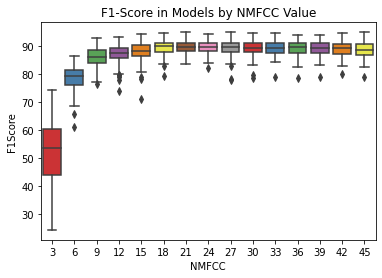

In [ ]:
import seaborn as sb

sb.boxplot(x='NMFCC', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by NMFCC Value")


Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

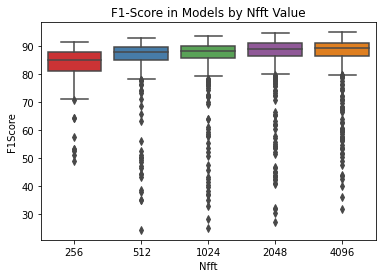

In [ ]:
sb.boxplot(x='Nfft', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Nfft Value")

Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

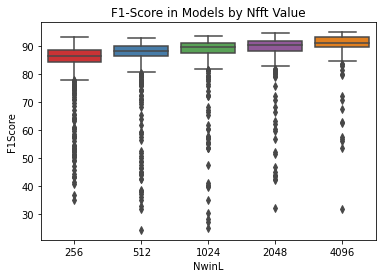

In [ ]:
sb.boxplot(x='NwinL', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Nfft Value")

Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

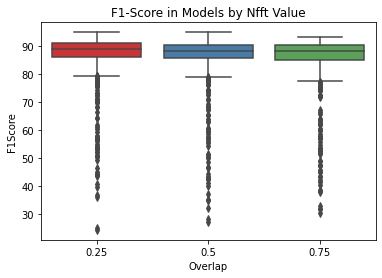

In [ ]:
sb.boxplot(x='Overlap', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Nfft Value")

Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

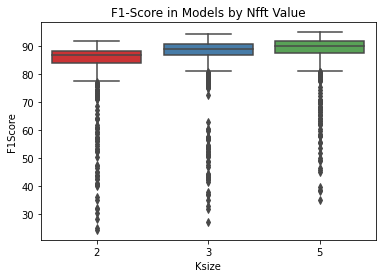

In [ ]:
sb.boxplot(x='Ksize', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Nfft Value")

In [ ]:
import statsmodels.api as sm 

formula = 'F1Score ~ NMFCC + Nfft'
model = sm.formula.ols(formula, data=dfExperiments).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
NMFCC,56917.340106,1.0,767.858634,1.547837e-143
Nfft,2264.487571,1.0,30.549677,3.675198e-08
Residual,149880.272945,2022.0,NaN,NaN


In [ ]:
formula = 'F1Score ~ NMFCC + Nfft + NMFCC:Nfft'
model = sm.formula.ols(formula, data=dfExperiments).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
NMFCC,56917.340106,1.0,770.396984,6.311366e-144
Nfft,2264.487571,1.0,30.650666,3.491715e-08
NMFCC:Nfft,567.714964,1.0,7.684229,5.621617e-03
Residual,149312.557982,2021.0,NaN,NaN


In [ ]:
formula = 'F1Score ~ NMFCC + Nfft + NwinL + Overlap + Ksize'
model = sm.formula.ols(formula, data=dfExperiments).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
NMFCC,56917.340106,1.0,805.662179,2.021180e-149
Nfft,518.931738,1.0,7.345453,6.780140e-03
NwinL,1609.720101,1.0,22.785510,1.941287e-06
Overlap,370.049067,1.0,5.238027,2.220119e-02
Ksize,5264.902146,1.0,74.524434,1.193185e-17
Residual,142635.601632,2019.0,NaN,NaN


#SCREAM EXPERIMENTS ANALYSIS

In [ ]:

AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_scream.csv"



import datetime
import pandas as pd     # Import pandas library


dfExperiments = pd.read_csv(AVGDataOutputPathScream, index_col=0)
dfExperiments
dfExperiments.sort_values(by='F1Score', ascending=False)

,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan
38,3,1024,512,128,0.75,5,0 days 00:00:00.043515,0 days 00:01:47.401915,99.0,99.0,80
65,3,2048,512,128,0.75,5,0 days 00:00:00.055147,0 days 00:02:04.831246,99.0,99.0,79
523,12,4096,2048,512,0.75,3,0 days 00:00:00.048121,0 days 00:01:59.524803,98.8,98.8,80
95,3,4096,256,128,0.50,5,0 days 00:00:00.073785,0 days 00:02:11.053457,98.6,98.6,80
2008,45,4096,2048,512,0.75,3,0 days 00:00:00.052758,0 days 00:02:59.531017,98.4,98.4,80
...,...,...,...,...,...,...,...,...,...,...,...
168,6,1024,256,192,0.25,2,0 days 00:00:00.041559,0 days 00:00:11.061575,57.2,71.4,22
144,6,512,256,64,0.75,2,0 days 00:00:00.045599,0 days 00:00:11.059989,56.8,71.4,18
9,3,512,256,64,0.75,2,0 days 00:00:00.045559,0 days 00:00:11.401934,56.8,70.0,21
174,6,1024,512,256,0.50,2,0 days 00:00:00.040029,0 days 00:00:42.120218,55.6,72.0,41


In [ ]:
dfExperiments.groupby(['NMFCC'])['F1Score'].mean()

NMFCC
3     87.085926
6     87.651852
9     89.380741
12    90.945185
15    90.408889
18    90.060741
21    89.560000
24    89.152593
27    89.365926
30    88.802963
33    88.391111
36    88.761481
39    88.841481
42    88.168889
45    88.248889
Name: F1Score, dtype: float64

Text(0.5, 1.0, 'F1-Score in Models by NMFCC Value')

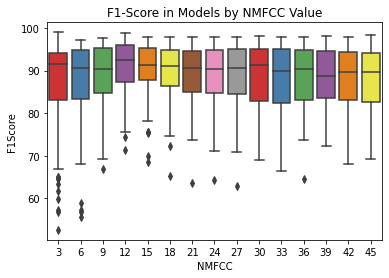

In [ ]:
import seaborn as sb

sb.boxplot(x='NMFCC', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by NMFCC Value")


Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

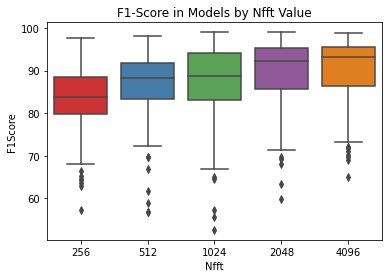

In [ ]:
sb.boxplot(x='Nfft', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Nfft Value")

Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

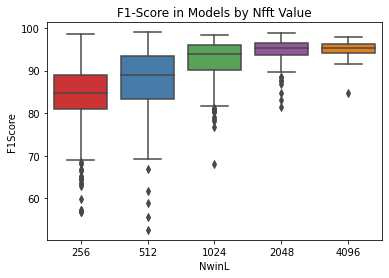

In [ ]:
sb.boxplot(x='NwinL', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by NwinL Value")

Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

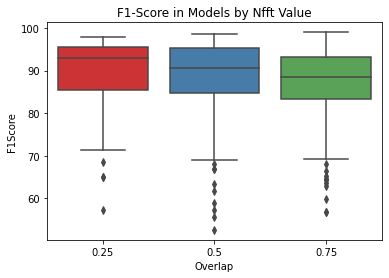

In [ ]:
sb.boxplot(x='Overlap', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Overlap Value")

Text(0.5, 1.0, 'F1-Score in Models by Nfft Value')

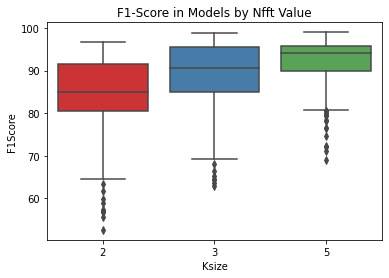

In [ ]:
sb.boxplot(x='Ksize', y='F1Score', data=dfExperiments, palette='Set1')
plt.title("F1-Score in Models by Ksize Value")

In [ ]:
import statsmodels.api as sm 

formula = 'F1Score ~ NMFCC + Nfft'
model = sm.formula.ols(formula, data=dfExperiments).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
NMFCC,38.630438,1.0,0.824732,3.639086e-01
Nfft,6381.690523,1.0,136.244448,1.639695e-30
Residual,94710.488639,2022.0,NaN,NaN


In [ ]:
formula = 'F1Score ~ NMFCC + Nfft + NMFCC:Nfft'
model = sm.formula.ols(formula, data=dfExperiments).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
NMFCC,38.630438,1.0,0.824918,3.638546e-01
Nfft,6381.690523,1.0,136.275145,1.617827e-30
NMFCC:Nfft,68.163846,1.0,1.455576,2.277765e-01
Residual,94642.324793,2021.0,NaN,NaN


In [ ]:
formula = 'F1Score ~ NMFCC + Nfft + NwinL + Overlap + Ksize'
model = sm.formula.ols(formula, data=dfExperiments).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
NMFCC,38.630438,1.0,1.315221,2.515875e-01
Nfft,83.197398,1.0,2.832557,9.252577e-02
NwinL,16534.198313,1.0,562.927036,5.714495e-110
Overlap,2485.006341,1.0,84.605085,8.807628e-20
Ksize,16389.555251,1.0,558.002486,3.939752e-109
Residual,59301.728734,2019.0,NaN,NaN


#SUMMARY EXPERIMENTS ANALYSIS

In [9]:
AVGDataOutputPathGun = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_gunshot.csv"

import datetime
import pandas as pd     # Import pandas library
import seaborn as sb

dfExperimentsGun = pd.read_csv(AVGDataOutputPathGun, index_col=0)
dfExperimentsGun
dfExperimentsGun.sort_values(by='F1Score', ascending=False)

,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan
1883,42,4096,4096,1024,0.75,5,0 days 00:00:00.061931,0 days 00:01:47.731802,97.2,97.2,80
1343,30,4096,4096,1024,0.75,5,0 days 00:00:00.057609,0 days 00:01:42.529743,97.0,97.2,80
1613,36,4096,4096,1024,0.75,5,0 days 00:00:00.068520,0 days 00:01:55.461854,97.0,97.0,80
1748,39,4096,4096,1024,0.75,5,0 days 00:00:00.055669,0 days 00:01:33.194341,97.0,97.2,80
266,6,4096,4096,2048,0.50,5,0 days 00:00:00.064598,0 days 00:01:48.970059,96.8,96.8,78
...,...,...,...,...,...,...,...,...,...,...,...
282,9,512,256,128,0.50,2,0 days 00:00:00.062682,0 days 00:00:56.805968,63.2,76.6,38
573,15,1024,256,192,0.25,2,0 days 00:00:00.054346,0 days 00:00:44.362996,63.0,75.8,40
543,15,256,256,128,0.50,2,0 days 00:00:00.052737,0 days 00:00:48.998795,56.8,73.6,42
546,15,256,256,192,0.25,2,0 days 00:00:00.051326,0 days 00:00:37.258240,53.8,71.4,35


In [10]:
AVGDataOutputPathSiren = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_siren.csv"

dfExperimentsSiren = pd.read_csv(AVGDataOutputPathSiren, index_col=0)
dfExperimentsSiren
dfExperimentsSiren.sort_values(by='F1Score', ascending=False)



,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan
2024,45,4096,4096,3072,0.25,5,0 days 00:00:00.081230,0 days 00:01:35.396707,95.0,95.2,77
944,21,4096,4096,3072,0.25,5,0 days 00:00:00.069288,0 days 00:01:43.231068,95.0,95.2,75
1211,27,4096,4096,2048,0.50,5,0 days 00:00:00.082391,0 days 00:02:08.044199,95.0,95.0,76
809,18,4096,4096,3072,0.25,5,0 days 00:00:00.070450,0 days 00:01:53.739414,94.8,94.8,77
899,21,2048,2048,1536,0.25,5,0 days 00:00:00.068077,0 days 00:02:04.464634,94.6,94.6,78
...,...,...,...,...,...,...,...,...,...,...,...
72,3,2048,1024,256,0.75,2,0 days 00:00:00.075878,0 days 00:00:30.822718,30.4,57.2,37
48,3,1024,1024,512,0.50,2,0 days 00:00:00.067897,0 days 00:00:21.897866,28.2,57.8,36
76,3,2048,1024,512,0.50,3,0 days 00:00:00.068277,0 days 00:00:38.049187,27.0,58.2,41
51,3,1024,1024,768,0.25,2,0 days 00:00:00.065881,0 days 00:00:26.218929,24.8,56.8,38


In [11]:
AVGDataOutputPathScream = "/content/drive/MyDrive/Colab Notebooks/Urban Sound Detection/Models/DSE_Models/output_data/AVG_data_out_scream.csv"

dfExperimentsScream = pd.read_csv(AVGDataOutputPathScream, index_col=0)
dfExperimentsScream
dfExperimentsScream.sort_values(by='F1Score', ascending=False)

,NMFCC,Nfft,NwinL,NhopL,Overlap,Ksize,AVGPreprocesTime,AVGTrainTime,F1Score,TestAcc,EpochsRan
38,3,1024,512,128,0.75,5,0 days 00:00:00.043515,0 days 00:01:47.401915,99.0,99.0,80
65,3,2048,512,128,0.75,5,0 days 00:00:00.055147,0 days 00:02:04.831246,99.0,99.0,79
523,12,4096,2048,512,0.75,3,0 days 00:00:00.048121,0 days 00:01:59.524803,98.8,98.8,80
95,3,4096,256,128,0.50,5,0 days 00:00:00.073785,0 days 00:02:11.053457,98.6,98.6,80
2008,45,4096,2048,512,0.75,3,0 days 00:00:00.052758,0 days 00:02:59.531017,98.4,98.4,80
...,...,...,...,...,...,...,...,...,...,...,...
168,6,1024,256,192,0.25,2,0 days 00:00:00.041559,0 days 00:00:11.061575,57.2,71.4,22
144,6,512,256,64,0.75,2,0 days 00:00:00.045599,0 days 00:00:11.059989,56.8,71.4,18
9,3,512,256,64,0.75,2,0 days 00:00:00.045559,0 days 00:00:11.401934,56.8,70.0,21
174,6,1024,512,256,0.50,2,0 days 00:00:00.040029,0 days 00:00:42.120218,55.6,72.0,41


Text(0.5, 1.0, 'Scream')

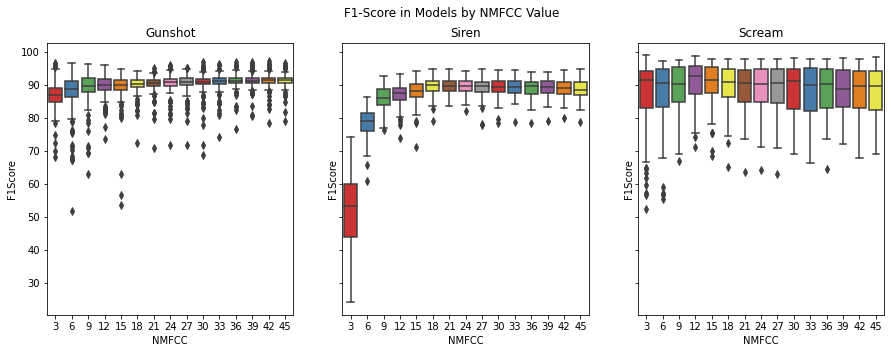

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by NMFCC Value')


# Gunshot
sb.boxplot(ax=axes[0], x='NMFCC', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='NMFCC', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='NMFCC', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

Text(0.5, 1.0, 'Scream')

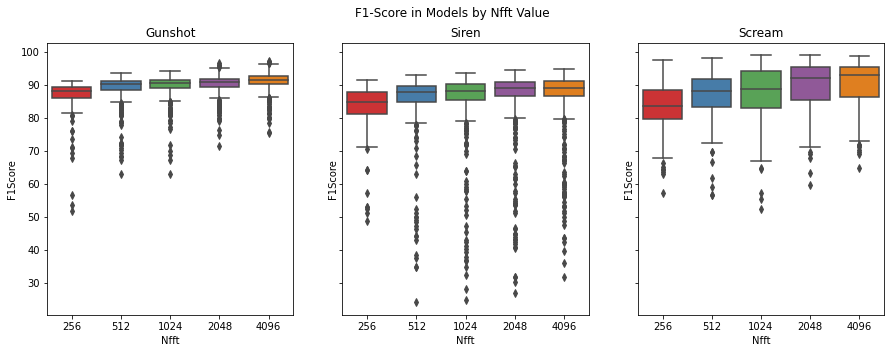

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by Nfft Value')


# Gunshot
sb.boxplot(ax=axes[0], x='Nfft', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='Nfft', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='Nfft', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

Text(0.5, 1.0, 'Scream')

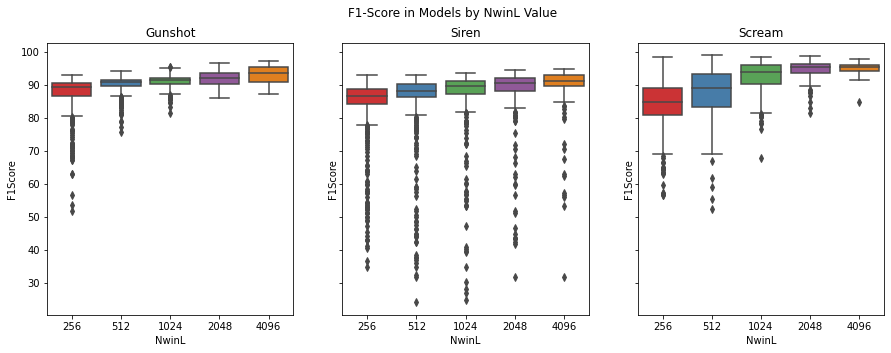

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by NwinL Value')


# Gunshot
sb.boxplot(ax=axes[0], x='NwinL', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='NwinL', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='NwinL', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

Text(0.5, 1.0, 'Scream')

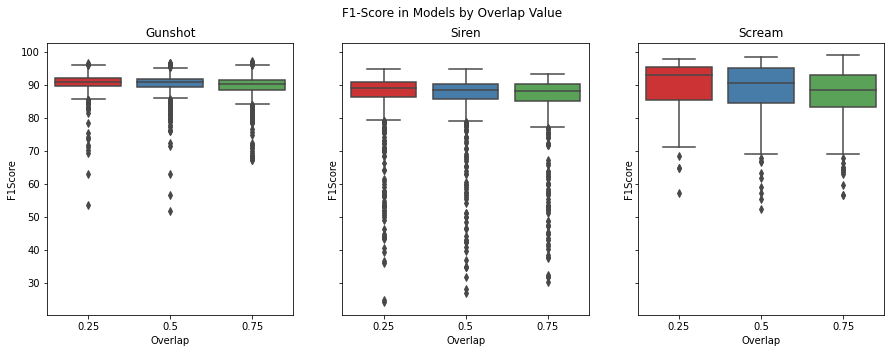

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by Overlap Value')


# Gunshot
sb.boxplot(ax=axes[0], x='Overlap', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='Overlap', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='Overlap', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

Text(0.5, 1.0, 'Scream')

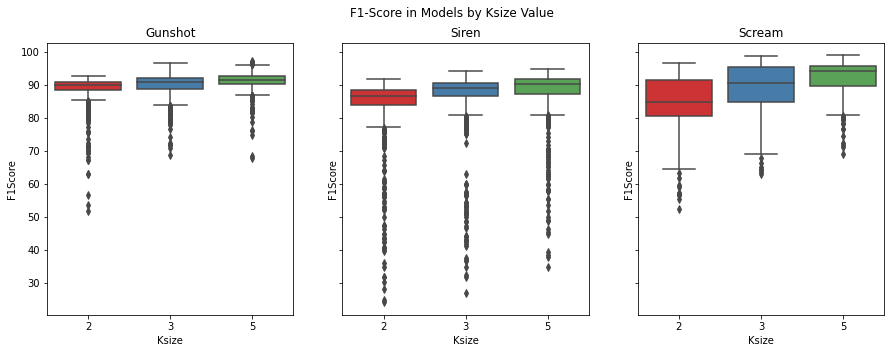

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('F1-Score in Models by Ksize Value')


# Gunshot
sb.boxplot(ax=axes[0], x='Ksize', y='F1Score', data=dfExperimentsGun, palette='Set1')
axes[0].set_title("Gunshot")

# Siren
sb.boxplot(ax=axes[1], x='Ksize', y='F1Score', data=dfExperimentsSiren, palette='Set1')
axes[1].set_title("Siren")

# Scream
sb.boxplot(ax=axes[2], x='Ksize', y='F1Score', data=dfExperimentsScream, palette='Set1')
axes[2].set_title("Scream")

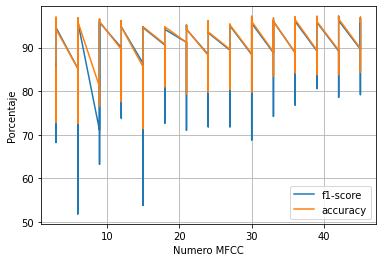

In [17]:
# Plotting Accuracy and F1-Score of Models

plt.plot('NMFCC','F1Score',  label='f1-score', data=dfExperimentsGun)
plt.plot('NMFCC','TestAcc', label='accuracy', data=dfExperimentsGun)
plt.xlabel('Numero MFCC')
plt.ylabel('Porcentaje')
plt.legend()
plt.grid(True)

In [ ]:
!pip install pingouin

In [20]:
import pingouin as pg
from statsmodels.graphics.factorplots import interaction_plot
# Test de normalidad Shapiro-Wilk
# ==============================================================================
pg.normality(data=dfExperimentsGun, dv='F1Score', group='NMFCC')

,W,pval,normal
NMFCC,,,
3,0.932684,4.549760e-06,False
6,0.809427,5.858370e-12,False
9,0.801085,2.987231e-12,False
12,0.897349,3.546698e-08,False
15,0.567353,3.011355e-18,False
18,0.755050,9.940872e-14,False
21,0.707117,4.504345e-15,False
24,0.745705,5.268022e-14,False
27,0.781895,6.808529e-13,False


In [21]:
# Test de homocedasticidad
# ==============================================================================
pg.homoscedasticity(data=dfExperimentsGun, dv='F1Score', group='NMFCC', method='levene')

,W,pval,equal_var
levene,11.457946,7.896680e-26,False
